# Regularyzacja w modelu regresji - wstęp

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from scipy import stats
from patsy import dmatrices

from statsmodels.api import OLS, add_constant
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

# Zadanie 1a

Wygeneruj $n$ par punktów (x, y) takich, że
$$
y = x - 2x^2 + 0.5x^3 + e,
$$
gdzie $e\sim\mathcal{N}(\mu, \sigma)$. 
A następnie dopasuj model

a) regresji liniowej: $y=\beta_0 + \beta_1\cdot x$

b) regresji wielomianowej stopnia 2: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2$,

c) regresji wielomianowej stopnia 3: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \beta_3\cdot x^3$,

d) regresji wielomianowej stopnia 20: $y=\beta_0 + \beta_1\cdot x + \beta_2\cdot x^2 + \ldots + \beta_{20}\cdot x^{20}$.

Zaznacz na wykresie rozproszenia punktów $(x, y)$ funkcję regresji.

**Wskazówka**: `ols('y ~ x + I(x**k)', data_frame)` ze `statsmodels.formula.api` lub `PolynomialFeatures` z `sklearn.preprocessing`

In [2]:
#generujemy dane
n = 50
x = stats.uniform.rvs(size=n, loc=-3, scale=6)
y = x - 2 * x**2 + 0.5 * x **3 + stats.norm.rvs(size=n, loc=2, scale=2)

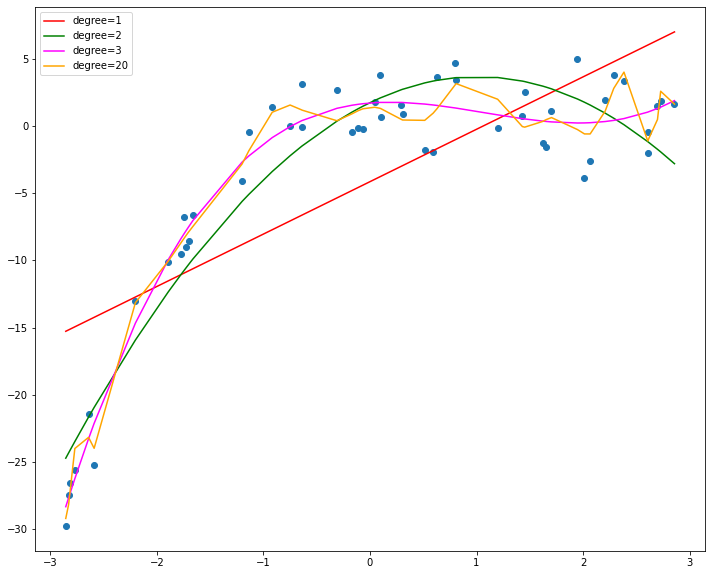

In [3]:
#rysujemy dopasowanie dla modeli wielomianowych o rzędzie wielomianu równym: 1, 2, 3 i 20
import operator

colors = ['red', 'green', 'magenta', 'orange']
degrees = [1, 2, 3, 20]

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

for i, deg in enumerate(degrees):
    
    if deg == 1:
        X = add_constant(x, prepend=True, has_constant='skip')
    
    else:
        polynomial_features = PolynomialFeatures(degree=deg)
        X = polynomial_features.fit_transform(x.reshape(-1, 1))
    
    model = OLS(endog=y, exog=X).fit()
    
    sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    
    plt.plot(x_range, y_poly_pred, color=colors[i], label="degree={}".format(deg))

plt.legend()

# Zadanie 1b

Dla wygenerowanych par punktów dopasuj model regresji:

a) wielomianowej stopnia 20 z regularyzacją grzbietową (Ridge) z parametrem $\alpha = 0.1$,

b) wielomianowej stopnia 20 z regularyzacją Lasso z parametrem $\alpha = 0.1$.

Powtórz podpunkt a) i b) dla różnych wartości parametru $\alpha$, np. $\alpha \in \{0.001, 0.005, 0.01, 0.5, 1, 5\}$.

In [4]:
X = x.reshape(-1, 1)
polynomial_features = PolynomialFeatures(degree=20, include_bias=False)  # 'sklearn' domyślnie dodaje wyraz wolny do modelu
X20 = polynomial_features.fit_transform(X)

In [5]:
X20.shape

(50, 20)

In [6]:
X20_scale = StandardScaler().fit_transform(X20)  # odjęcie średniej i podzielenie przez odchylenie standardowe

In [7]:
ridge01 = Ridge(alpha=0.1).fit(X=X20_scale, y=y)  # regularyzacja: regresja grzebietowa

In [8]:
lm = LinearRegression().fit(X=X20_scale, y=y)  # zwykły model regresji liniowej

In [9]:
print(ridge01.coef_)
print(lm.coef_)

[ 1.02164742 -4.23165405  5.33204036 -1.73875723  2.43731882  0.79247032
  0.34552166  0.61115069 -0.91622893 -0.0714369  -1.43260139 -0.42954011
 -1.29196349 -0.39780392 -0.61466586 -0.14354914  0.46401072  0.14641271
  1.81512136  0.33180633]
[ 1.25241650e+00 -4.59732099e+01 -1.02642084e+02  1.65397495e+03
  2.49478913e+03 -2.00647951e+04 -2.23834428e+04  1.18486920e+05
  1.05108017e+05 -4.00763563e+05 -2.86428968e+05  8.29841255e+05
  4.68289689e+05 -1.06968657e+06 -4.52099775e+05  8.36585068e+05
  2.37263909e+05 -3.62942850e+05 -5.21349830e+04  6.69319109e+04]


In [10]:
print(ridge01.intercept_)
print(lm.intercept_)

-3.771346335596621
-3.771346335584958


In [11]:
ridge01_fittedvalues = ridge01.predict(X20_scale)

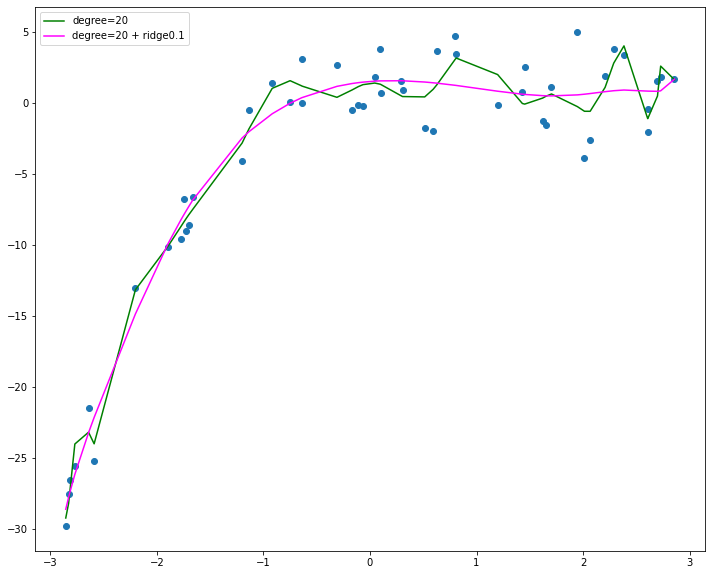

In [13]:
#wykres dopasowania dla regresji wielomianowej bez kary ridge, a także z tą karą

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))

plt.legend()
plt.show()

In [14]:
# a) regularyzacja grzbietowa (Ridge)

ridge01_pipeline = make_pipeline(PolynomialFeatures(degree=20, include_bias=False),
                                 StandardScaler(),
                                 Ridge(alpha=0.1)
                                 )

ridge01_pipeline = ridge01_pipeline.fit(X=X, y=y)

In [15]:
ridge01_pipeline["ridge"].coef_  # można odwoływać się do kolejnych elementów (po indeksie albo po nazwie)

array([ 1.02164742, -4.23165405,  5.33204036, -1.73875723,  2.43731882,
        0.79247032,  0.34552166,  0.61115069, -0.91622893, -0.0714369 ,
       -1.43260139, -0.42954011, -1.29196349, -0.39780392, -0.61466586,
       -0.14354914,  0.46401072,  0.14641271,  1.81512136,  0.33180633])

In [16]:
#  fitowanie do przeskalowanych zmiennych (poprzednia metoda)

ridge01_fittedvalues = ridge01.predict(X20_scale)
print(ridge01_fittedvalues)

[ 1.58929259e+00  6.86989669e-01  3.88630704e-01 -2.00705862e+00
 -8.22453420e+00 -6.80569375e+00  5.92528483e-01  5.29351996e-01
  8.59565124e-01  5.21939578e-01  8.44145234e-01  1.44602969e+00
  4.00207861e-01 -2.74660607e+01  6.41936802e-01 -2.44755753e+00
  1.26799417e+00  3.62467996e-03  1.57811080e+00  1.41919672e+00
 -2.61611913e+01  1.39188305e+00  1.55990038e+00 -7.88368970e+00
  1.45393313e+00 -7.36716064e-01 -9.87685060e+00 -1.48513322e+01
  1.70134669e+00  1.25854557e+00 -2.32267197e+01 -2.86171633e+01
  8.79482003e-01  1.49185861e+00  6.41240998e-01  9.35301132e-01
  1.58032490e+00  5.38562412e-01  1.49920993e+00 -7.30501218e+00
  8.86543821e-01  1.58690687e+00  6.26014292e-01  8.19123440e-01
 -2.77797265e+01 -2.21481064e+01  1.19457907e+00 -7.55413127e+00
  8.58110102e-01  8.51816634e-01]


In [17]:
ridge01_pipeline.predict(X)  # automatyczne skalowanie zmiennych wewnątrz 'make_pipeline()'

array([ 1.58929259e+00,  6.86989669e-01,  3.88630704e-01, -2.00705862e+00,
       -8.22453420e+00, -6.80569375e+00,  5.92528483e-01,  5.29351996e-01,
        8.59565124e-01,  5.21939578e-01,  8.44145234e-01,  1.44602969e+00,
        4.00207861e-01, -2.74660607e+01,  6.41936802e-01, -2.44755753e+00,
        1.26799417e+00,  3.62467996e-03,  1.57811080e+00,  1.41919672e+00,
       -2.61611913e+01,  1.39188305e+00,  1.55990038e+00, -7.88368970e+00,
        1.45393313e+00, -7.36716064e-01, -9.87685060e+00, -1.48513322e+01,
        1.70134669e+00,  1.25854557e+00, -2.32267197e+01, -2.86171633e+01,
        8.79482003e-01,  1.49185861e+00,  6.41240998e-01,  9.35301132e-01,
        1.58032490e+00,  5.38562412e-01,  1.49920993e+00, -7.30501218e+00,
        8.86543821e-01,  1.58690687e+00,  6.26014292e-01,  8.19123440e-01,
       -2.77797265e+01, -2.21481064e+01,  1.19457907e+00, -7.55413127e+00,
        8.58110102e-01,  8.51816634e-01])

In [18]:
# b) regularyzacja liniowa (Lasso)

lasso01_pipeline = make_pipeline(PolynomialFeatures(degree=20, include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=0.1)
                                 )

lasso01_pipeline = lasso01_pipeline.fit(X=X, y=y)

In [26]:
lasso01_fittedvalues = lasso01_pipeline.predict(X)
lasso01_pipeline.predict(X)  # automatyczne skalowanie zmiennych wewnątrz 'make_pipeline()'

array([  1.53008551,   0.40434462,   0.2703224 ,  -2.16028235,
        -8.07084545,  -6.75246548,   0.38565524,   0.46414683,
         0.97058583,   0.44032107,   1.16377752,   1.38867093,
         0.28236268, -27.25381255,   0.61634441,  -2.59495535,
         1.21756663,  -0.12846179,   1.51771358,   1.36259314,
       -26.05087279,   1.32216729,   1.49864621,  -7.75491123,
         1.38743894,  -0.88629195,  -9.59949213, -14.2698741 ,
         1.56707224,   1.20859661, -22.99685083, -28.21344125,
         1.23208937,   1.42728863,   0.39191986,   0.63278048,
         1.5200324 ,   0.48302897,   1.44071611,  -7.21750618,
         0.53377591,   1.52770567,   0.59873403,   0.47101607,
       -27.5248591 , -21.81617556,   1.11441037,  -7.4490368 ,
         0.97492802,   0.82598052])

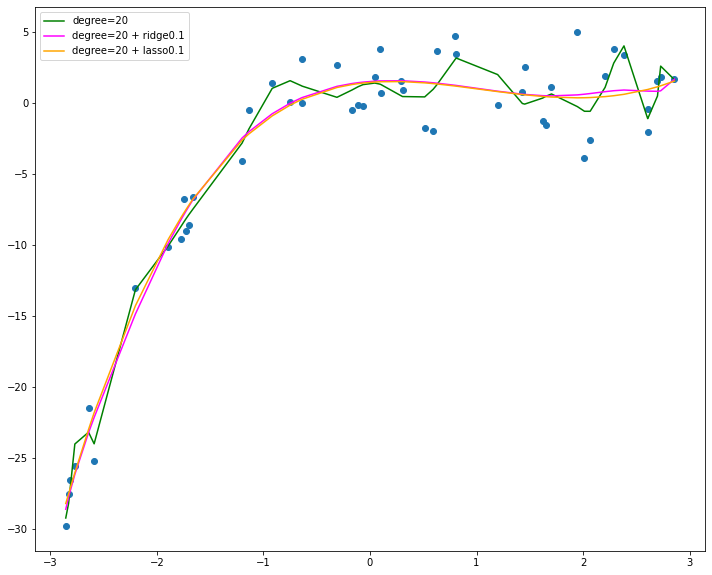

In [25]:
#wykres dopasowania dla regresji wielomianowej bez kary ridge, a także z tą karą

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[2], label="degree={} + ridge0.1".format(deg))

sorted_zip = sorted(zip(x, lasso01_fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[3], label="degree={} + lasso0.1".format(deg))

plt.legend()
plt.show()

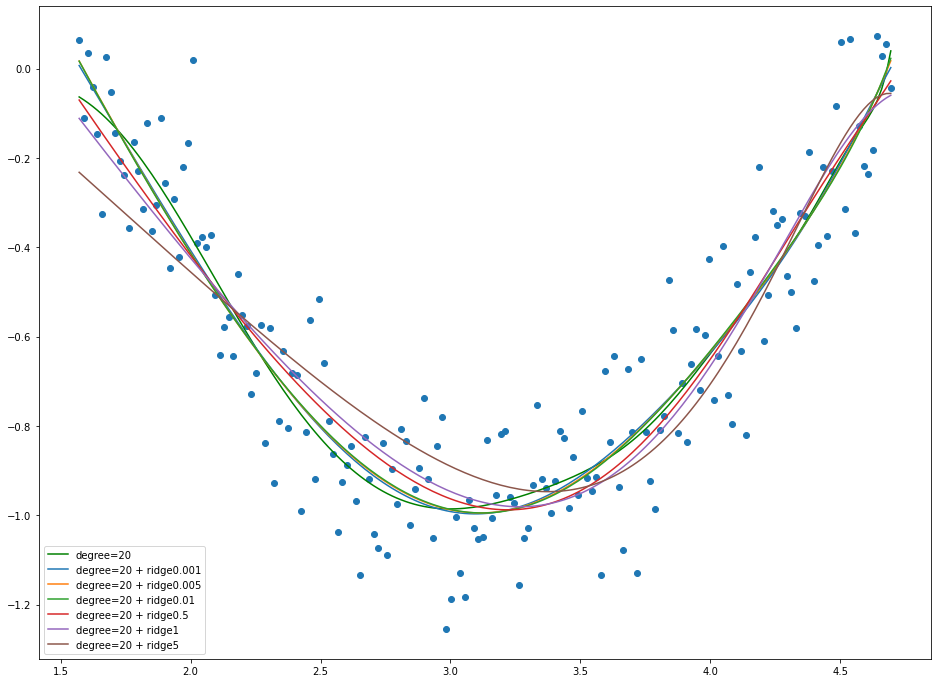

In [60]:
# porównanie różnych hiperparametrów alpha dla regularyzacji grzbietowej (Ridge)

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

alpha_values = [0.001, 0.005, 0.01, 0.5, 1, 5]
for alpha in alpha_values:
    ridge01_pipeline = make_pipeline(PolynomialFeatures(degree=20, include_bias=False),
                                     StandardScaler(),
                                     Ridge(alpha=alpha)
                                     )

    ridge01_pipeline = ridge01_pipeline.fit(X=X, y=y)
    ridge01_fittedvalues = ridge01_pipeline.predict(X)

    sorted_zip = sorted(zip(x, ridge01_fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    plt.plot(x_range, y_poly_pred, label="degree={} + ridge{}".format(deg, alpha))

plt.legend()
plt.show()

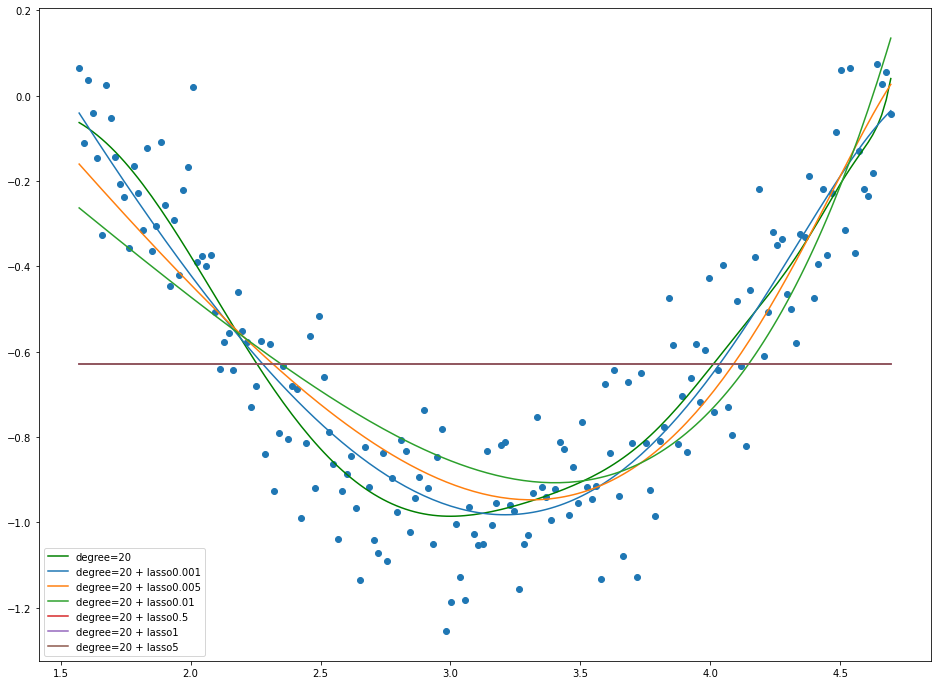

In [62]:
# regularyzacja liniowa (Lasso)

plt.scatter(x, y)
sort_axis = operator.itemgetter(0)

polynomial_features = PolynomialFeatures(degree=20)
X20 = polynomial_features.fit_transform(x.reshape(-1, 1))
model = OLS(endog=y, exog=X20).fit()

sorted_zip = sorted(zip(x, model.fittedvalues), key=sort_axis)
x_range, y_poly_pred = zip(*sorted_zip)
plt.plot(x_range, y_poly_pred, color=colors[1], label="degree={}".format(deg))

alpha_values = [0.001, 0.005, 0.01, 0.5, 1, 5]
for alpha in alpha_values:
    lasso01_pipeline = make_pipeline(PolynomialFeatures(degree=20, include_bias=False),
                                 StandardScaler(),
                                 Lasso(alpha=alpha, max_iter=10_000)
                                 )

    lasso01_pipeline = lasso01_pipeline.fit(X=X, y=y)
    lasso01_fittedvalues = lasso01_pipeline.predict(X)

    sorted_zip = sorted(zip(x, lasso01_fittedvalues), key=sort_axis)
    x_range, y_poly_pred = zip(*sorted_zip)
    plt.plot(x_range, y_poly_pred, label="degree={} + lasso{}".format(deg, alpha))

plt.legend()
plt.show()

# Zadanie 2

Narysuj wykres funkcji 
$$y = cos(x) + \epsilon$$
dla $x \in [\frac{\pi}{2}, \frac{3}{2}\pi]$ oraz $\epsilon \in N(0, 0.15)$.

Dopasuj model regresji:
- liniowej
- wielomianowej stopnia 2, 10 i 20,
- wielomianowej stopnia 20 z regularyzacja Ridge z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.
- wielomianowej stopnia 20 z regularyzacją Lasso z parametrem $\alpha\in\{0.001, 0.01, 0.1, 1, 2\}$.

**Wskazówka**: Napisz funkcję, która dla dowolnego zbioru dopasuje odpowiedni model.

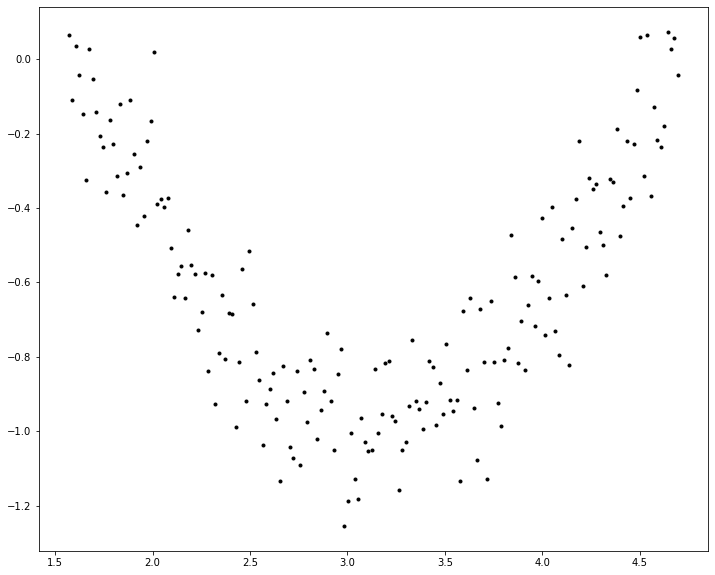

In [27]:
#generacja danych

x = np.array([i * np.pi / 180 for i in range(90, 270, 1)])
X = pd.DataFrame(x)
y = np.cos(x) + np.random.normal(0, 0.15, len(x))

plt.plot(x, y, '.', color='black')

In [28]:
#funkcja dopasowywująca modele, które nas interesują

def fit_model(X, y, model, power):
    
    new_model = make_pipeline(PolynomialFeatures(degree=power, include_bias=False), StandardScaler(), model)
    new_model.fit(X,y)
    
    return(new_model.predict(X))

In [47]:
#tworzymy modele

models = {}
models['linear_regression'] = {'power': 1, 'model': LinearRegression()}
models['polynomial_regression2'] = {'power': 2, 'model': LinearRegression()}
models['polynomial_regression10'] = {'power': 10, 'model': LinearRegression()}
models['polynomial_regression20'] = {'power': 20, 'model': LinearRegression()}
models['ridge_regression_0.1'] = {'power': 20, 'model': Ridge(alpha = 0.1)}
models['lasso_regression_0.1'] = {'power': 20, 'model': Lasso(alpha = 0.1)}

In [48]:
#definiujemy miarę RSS (czyli właściwie MSE razy liczba obserwacji)

def rss_fun(y,y_pred):
    return(sum((y - y_pred)**2))

In [49]:
#liczymy RSS dla każdego modelu na danych na których uczyliśmy model

y_pred_dict = {}
rss = {}

for key, values in zip(models, models.values()):
    
    y_pred = fit_model(X, y, values['model'], values['power'])
    y_pred_dict[key] = y_pred
    rss[key] = rss_fun(y_pred, y)

In [50]:
pd.DataFrame(list(rss.items()), columns = ['Model', 'RSS'])

,Model,RSS
0,linear_regression,20.099776
1,polynomial_regression2,3.213169
2,polynomial_regression10,3.017047
3,polynomial_regression20,2.948842
4,ridge_regression_0.1,3.165760
5,lasso_regression_0.1,16.523006


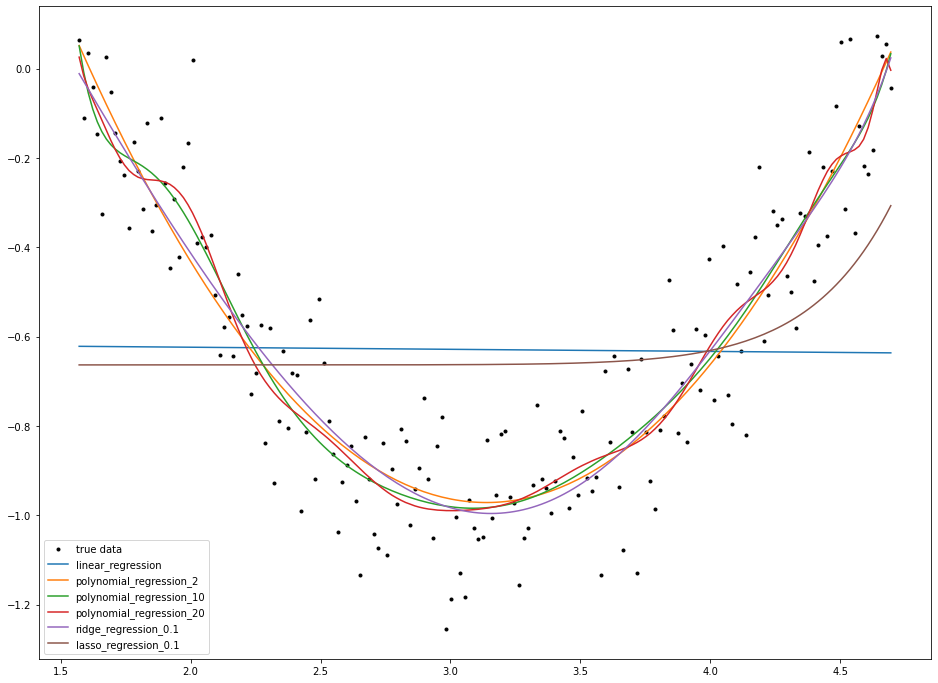

In [51]:
# polynomial 20 przeuczony, ridge z alpha = 0.1 ok, lasso z alpha = 0.1 niedouczony (powinniśmy zmniejszych alpha=0.005)

rcParams['figure.figsize'] = 16, 12

labels = ['true data'] + ['linear_regression', 'polynomial_regression_2', 
                          'polynomial_regression_10', 'polynomial_regression_20', 
                          'ridge_regression_0.1', 'lasso_regression_0.1']

plt.plot(x, y, '.', color = 'black', label="data")

for y_pred in y_pred_dict.values():
    
    plt.plot(x, y_pred)
    plt.legend(labels)